In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import cg

import jlinops
import sampi

# Transformed regularized least-squares

# Type 1, R is invertible.

In [2]:
n = 100
A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4)
#A = jlinops.IdentityOperator((n,n))
Rmat, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
R = jlinops.MatrixLinearOperator(Rmat)
b = A.matvec(np.cumsum(np.random.normal(size=n)))
Rinv = jlinops.MatrixLinearOperator(np.linalg.inv(Rmat.toarray()))

In [3]:
lam = 1e3

shift = 5.0*np.random.normal(size=R.shape[0])
data_trlstsq_rinv = jlinops.trlstsq_rinv(A, Rinv, b, lam=lam, tol=1e-8, shift=shift)
data_trlstsq = jlinops.trlstsq(A, R, b, lam=lam, tol=1e-8, shift=shift)

Q = (A.T @ A) + lam*(R.T @ R)
scipy_cg_sol, _ = cg(Q, (A.T @ b) + lam*(R.T @ shift) , tol=1e-8, x0=np.ones(n))

In [4]:
print(np.linalg.norm(data_trlstsq["x"] - scipy_cg_sol))

7.258396848468482e-12


In [5]:
print(np.linalg.norm(data_trlstsq_rinv["x"] - scipy_cg_sol))

5.174043725765317e-08


In [6]:
print(np.linalg.norm(data_trlstsq_rinv["x"] - data_trlstsq["x"] ))

5.174034899928668e-08


In [7]:
data_trlstsq_rinv["converged"]

True

In [8]:
data_trlstsq["converged"]

True

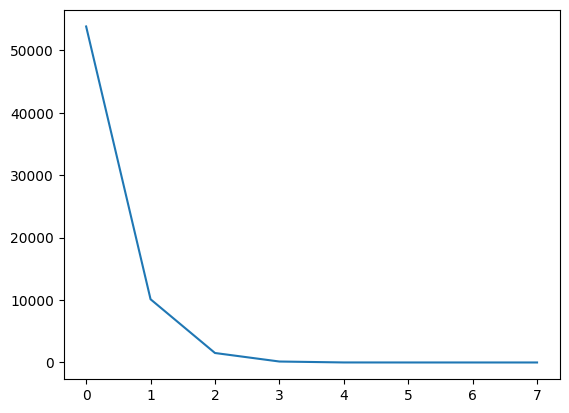

In [9]:
plt.plot(data_trlstsq_rinv["At_residual_norms"])
plt.show()

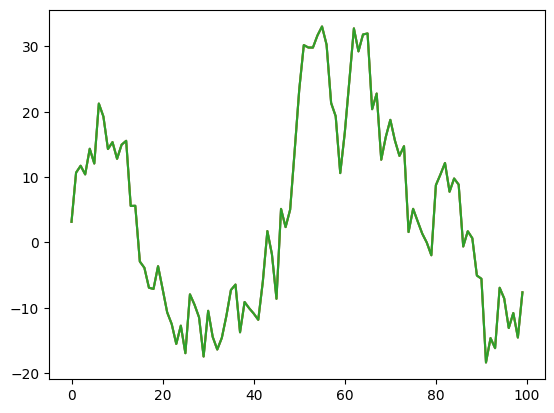

In [10]:
plt.plot(data_trlstsq_rinv["x"])
plt.plot(data_trlstsq["x"])
plt.plot(scipy_cg_sol)
plt.show()

# R noninvertible but with trivial kernel

In [11]:
from scipy.linalg import null_space

In [12]:
n = 25
A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4)
#A = jlinops.IdentityOperator((n,n))
Rmat, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
Rmat = Rmat.toarray()
Rmat = np.vstack([Rmat, Rmat])
# Rmat = Rmat.T @ Rmat
R = jlinops.MatrixLinearOperator(Rmat)
Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(Rmat))
b = A.matvec(np.cumsum(np.random.normal(size=n)))
shift = 5.0*np.random.normal(size=R.shape[0])

In [13]:
lam = 1e1

#data_trlstsq_rinv = trlstsq_rinv(A, Rinv, b, lam=lam, tol=1e-3)
data_trlstsq = jlinops.trlstsq(A, R, b, lam=lam, tol=1e-3, shift=shift)
data_trlstsq_rtker = jlinops.trlstsq_rtker(A, Rpinv, b, lam=lam, R=R, tol=1e-3, shift=shift)

Q = (A.T @ A) + lam*(R.T @ R)
scipy_cg_sol, _ = cg(Q, (A.T @ b) + lam*(R.T @ shift), tol=1e-3)

In [14]:
print(np.linalg.norm(data_trlstsq_rtker["x"] - scipy_cg_sol))

0.20682649406327738


In [15]:
print(np.linalg.norm(data_trlstsq["x"] - scipy_cg_sol))

0.20622608797019262


In [16]:
print(np.linalg.norm(data_trlstsq["x"] - data_trlstsq_rtker["x"]))

0.0014948635630554405


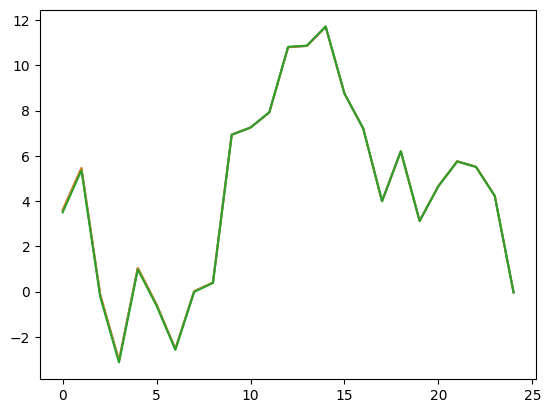

In [17]:
plt.plot(data_trlstsq["x"])
plt.plot(data_trlstsq_rtker["x"])
plt.plot(scipy_cg_sol)
plt.show()

In [18]:
n = 25
A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4)
#A = jlinops.IdentityOperator((n,n))
Rmat, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
Rmat = Rmat.toarray()
Rmat = np.vstack([Rmat, Rmat])
R = jlinops.MatrixLinearOperator(Rmat)
RtRchol = np.linalg.cholesky(Rmat.T @ Rmat)
Linv = np.linalg.inv(RtRchol)
Linv = jlinops.MatrixLinearOperator(Linv)
b = A.matvec(np.cumsum(np.random.normal(size=n)))
shift = 5.0*np.random.normal(size=R.shape[0])

In [19]:
lam = 1e1

#data_trlstsq_rinv = trlstsq_rinv(A, Rinv, b, lam=lam, tol=1e-3)
data_trlstsq = jlinops.trlstsq(A, R, b, lam=lam, tol=1e-3, shift=shift)
data_trlstsq_rtker = jlinops.trlstsq_rtker(A, Linv.T, b, lam=lam, tol=1e-3, R=R, chol_fac=True, shift=shift)

Q = (A.T @ A) + lam*(R.T @ R)
scipy_cg_sol, _ = cg(Q, (A.T @ b) + lam*(R.T @ shift), tol=1e-3)

In [20]:
print(np.linalg.norm(data_trlstsq_rtker["x"] - scipy_cg_sol))

0.0023126610769687167


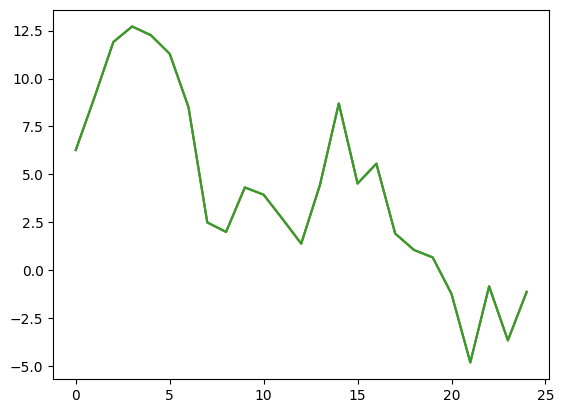

In [21]:
plt.plot(data_trlstsq["x"])
plt.plot(data_trlstsq_rtker["x"])
plt.plot(scipy_cg_sol)
plt.show()

### Which has better condition number?

In [22]:
Q1 = Rpinv.T @ ( A.T @ ( A @ Rpinv )) + jlinops.IdentityOperator( (Rpinv.shape[1], Rpinv.shape[1]) )
Q2 =  Linv @ ( A.T @ ( A @ Linv.T )) + jlinops.IdentityOperator( (Linv.shape[1], Linv.shape[1]) )

In [23]:
Q1mat = jlinops.black_box_to_dense(Q1)
Q2mat = jlinops.black_box_to_dense(Q2)

In [24]:
Q1mat.shape

(50, 50)

In [25]:
Q2mat.shape

(25, 25)

In [26]:
np.linalg.cond(Q1mat)

116.20807752092735

In [27]:
np.linalg.cond(Q2mat)

116.20807751979635

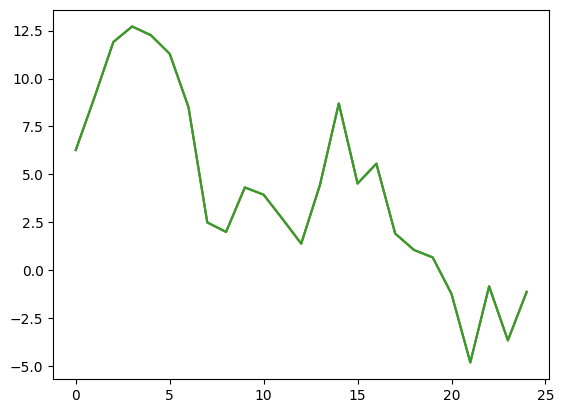

In [28]:
plt.plot(data_trlstsq["x"])
plt.plot(data_trlstsq_rtker["x"])
plt.plot(scipy_cg_sol)
plt.show()

# Oblique method for nontrivial kernel

In [29]:
from scipy.linalg import null_space

In [30]:
n = 25
A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=4)
#A = jlinops.IdentityOperator((n,n))
Rmat, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
Rmat = Rmat.toarray()
rows_to_drop = [10, 15]
Rmat = np.delete(Rmat, rows_to_drop, axis=0)
Wmat = null_space(Rmat)
R = jlinops.MatrixLinearOperator(Rmat)
W = jlinops.MatrixLinearOperator(Wmat)
# R = jlinops.MatrixLinearOperator(Rmat)
# RtRchol = np.linalg.cholesky(Rmat.T @ Rmat)
# Linv = np.linalg.inv(RtRchol)
# Linv = jlinops.MatrixLinearOperator(Linv)
b = A.matvec(np.cumsum(np.random.normal(size=n)))
shift = 5.0*np.random.normal(size=R.shape[0])

In [31]:
# Build oblique pseudoinverse
Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(Rmat))
# AWpinv = jlinops.QRPinvOperator( A.matmat(Wmat) )
# obl_op = ( jlinops.IdentityOperator((n,n)) -  W @ (AWpinv @ A)  ) @ Rpinv

In [32]:
lam = 1e0

#data_trlstsq_rinv = trlstsq_rinv(A, Rinv, b, lam=lam, tol=1e-3)
data_trlstsq = jlinops.trlstsq(A, R, b, lam=lam, tol=1e-3, shift=shift)
data_trlstsq_rntker = jlinops.trlstsq_rntker(A, Rpinv, W, b, lam=lam, tol=1e-8, R=R, shift=shift)

Q = (A.T @ A) + lam*(R.T @ R)
scipy_cg_sol, _ = cg(Q, (A.T @ b) + lam*(R.T @ shift) , tol=1e-3)

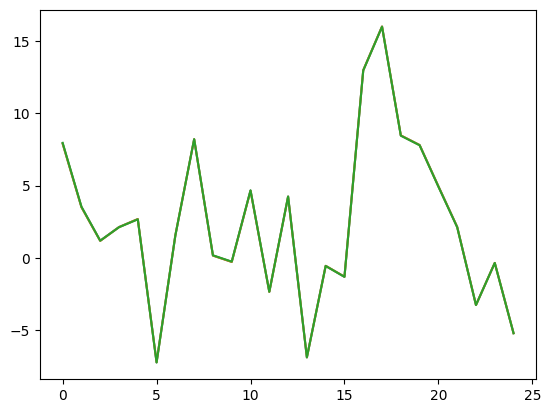

In [33]:
plt.plot(data_trlstsq["x"])
plt.plot(data_trlstsq_rntker["x"])
plt.plot(scipy_cg_sol)
plt.show()

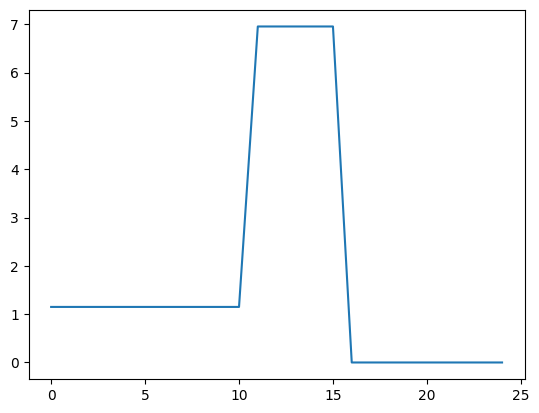

In [34]:
plt.plot(data_trlstsq_rntker["x_null"])
plt.show()

In [35]:
Qmat = jlinops.black_box_to_dense(Q)
print(np.linalg.cond(Qmat))

88.1039684784181


In [36]:
O = jlinops.black_box_to_dense(data_trlstsq_rntker["oblique_pinv"])

In [37]:
Otilde = (O.T @ O) + np.eye(O.shape[1])

In [38]:
print(np.linalg.cond(Otilde))

46.384645811908044


# General purpose function?

In [39]:
lam = 1e0

#data_trlstsq_rinv = trlstsq_rinv(A, Rinv, b, lam=lam, tol=1e-3)
#data_trlstsq = jlinops.trlstsq(A, R, b, lam=lam, tol=1e-3, shift=shift)
data = jlinops.trlstsq_standard_form(A, b, Rpinv=Rpinv, W=W, lam=lam, tol=1e-8, R=R, shift=shift)

Q = (A.T @ A) + lam*(R.T @ R)
scipy_cg_sol, _ = cg(Q, (A.T @ b) + lam*(R.T @ shift) , tol=1e-3)

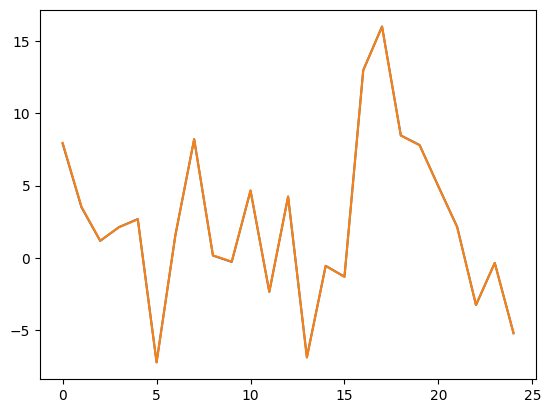

In [41]:
plt.plot(data["x"])
plt.plot(scipy_cg_sol)
plt.show()